In [1]:
import meep as mp
from meep import mpb

import numpy as np
import os

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
path = os.path.abspath(os.getcwd())
print(path)

/home/ben/Desktop/Thesis/github/Thesis_name/Simulations/04_Photonic_Crystal_Slabs/Hybridization


In [2]:
import sys
sys.path.append("/home/ben/Desktop/Thesis/github/Thesis_name/Simulations/")
from ExternalFunctions import (plot_unit_cell_cross_sections, geom_hexagon_PCS,
                              plot_epsilon_XY, geom_hexagon_PCS_slope, hexagonal_lattice_bands)
from ExternalFunctions import (calculate_ifield, plot_field_2D_YZ,  plot_field_2D_XZ,
                              plot_field_2D_XY, plot_intentsity_in_z_axis, geom_hexagon_PCS,
                              plot_unit_cell_cross_sections, plot_epsilon_XY)

In [3]:
f1 = np.genfromtxt(path+"/hybrid_bands.dat", delimiter=",")[1:,1:]

In [4]:
def hexagonal_lattice_bands(a, files):

    f1 = files

    fig, ax = plt.subplots(figsize=(14, 10))

    light_speed = 3e8

    w_to_n = 1#light_speed / (a * 10 ** 12)

    for i in range(1, 7):

        if i == 1:
            ax.plot(
                np.linspace(0, len(f1[:, 1]) - 1, len(f1[:, 1])),
                f1[:, -i] * (w_to_n),
                c="black",
                linestyle="dashed",
                label="Dispersion modes",
            )
        else:
            ax.plot(
                np.linspace(0, len(f1[:, 1]) - 1, len(f1[:, 1])),
                f1[:, -i] * (w_to_n),
                c="black",
                linestyle="dashed",
            )

    
    
    k_point = np.linspace(0, len(f1[:, 1]) - 1, len(f1[:, 1]))
    K_index = int(0.33 * len(f1[:, 1]))
    M_index = int(0.66 * len(f1[:, 1]))

    k_till_K = np.array(
        [
            np.linspace(0, 1 / np.sqrt(3), K_index + 1),
            np.linspace(0, 1 / 3, K_index + 1),
        ]
    )
    k_till_M = np.array(
        [
            1 / np.sqrt(3) * np.ones(M_index - K_index),
            np.linspace(1 / 3, 0, M_index - K_index),
        ]
    )
    k_till_Gamma = np.array(
        [
            np.linspace(1 / np.sqrt(3), 0, len(f1[:, 1]) - M_index),
            np.zeros(len(f1[:, 1]) - M_index),
        ]
    )

    ks = np.hstack([k_till_K, k_till_M[:, 1:], k_till_Gamma])
    Light_line = np.sqrt(ks[0, :] ** 2 + ks[1, :] ** 2)

    ax.plot(k_point, np.array(Light_line) * (w_to_n), c="r", label="Light line")
    ax.fill_between(
        k_point,
        Light_line * (w_to_n),
        np.ones_like(k_point) * (w_to_n),
        color="purple",
        alpha=0.9,
        label="Light cone",
    )

    plt.axvline(x=K_index, c="black", alpha=0.3)
    plt.axvline(x=M_index, c="black", alpha=0.3)

    ax.set_xticks([0, K_index, M_index, len(f1[:, 1])-1])
    ax.set_xticklabels(["$\\Gamma$", "K", "M", "$\\Gamma$"])
    ax.set_xlim([0, len(f1[:, 1]) - 1])
    ax.set_ylim([0, 0.75 * (w_to_n)])
    ax.set_xlabel("")
    ax.set_ylabel("Frequency $\\nu$ (THz)")
    ax.legend(loc=2)

    return fig, ax

(<Figure size 1008x720 with 1 Axes>,
 <AxesSubplot:ylabel='Frequency $\\nu$ (THz)'>)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


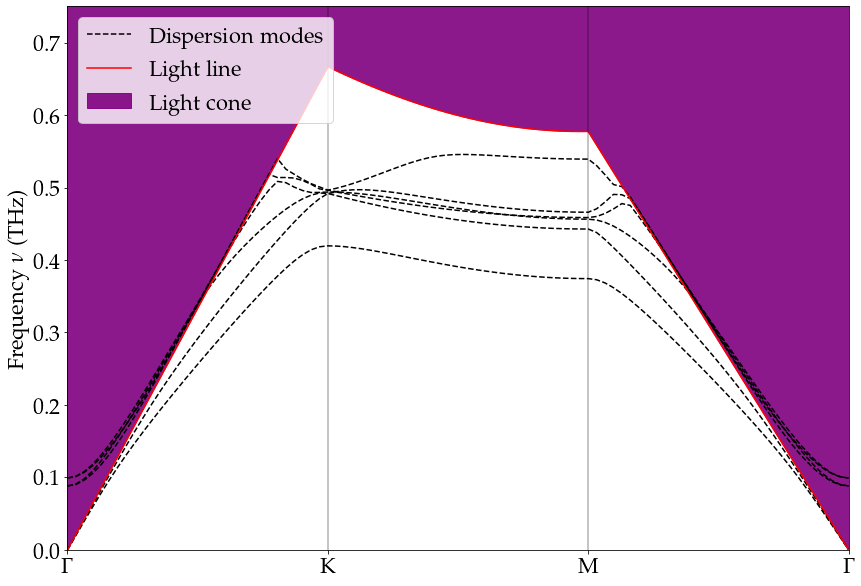

In [5]:
a = 1 # arbitrary units

hexagonal_lattice_bands(a, f1)

In [6]:
save = False
plot = True
simulate = False

In [7]:
resolution = 32
num_bands = 1

In [8]:
a = 405 # nm
t = 180 / a
scaling = (1-t)*0.5
g = 300 / a

In [9]:
sx = 1 
sy = 1 
sz = 10
cell = mp.Vector3(sx, sy, sz)

In [10]:
geometry = [mp.Block(center=mp.Vector3(0,0,0.5*g), size=mp.Vector3(mp.inf,mp.inf,t), material=mp.Medium(index = 1.9935))]
geometry.append(mp.Block(center=mp.Vector3(0,0,-0.5*g), size=mp.Vector3(mp.inf,mp.inf,t), material=mp.Medium(index = 1.9935)))

# A hexagonal prism defined by six vertices centered on the origin
# of material crystalline silicon (from the materials library)

multiplier = (1-t)*0.5

vertices = [mp.Vector3(multiplier*2/np.sqrt(3),0),
            mp.Vector3(multiplier*1/np.sqrt(3),multiplier*1),
            mp.Vector3(-multiplier*1/np.sqrt(3),multiplier*1),
            mp.Vector3(multiplier*-2/np.sqrt(3),0),
            mp.Vector3(-multiplier*1/np.sqrt(3),-multiplier*1),
            mp.Vector3(multiplier*1/np.sqrt(3),-multiplier*1)]

vertices_new = []

geometry_lattice = mp.Lattice(size=mp.Vector3(1, 1, sz),
                              basis1=mp.Vector3(np.sqrt(3) / 2, 0.5, 0.0),
                              basis2=mp.Vector3(np.sqrt(3) / 2, -0.5, 0.0))
vertices_new = []
for vertice in vertices:
    vertices_new.append(mp.cartesian_to_lattice(vertice, geometry_lattice))

geometry.append(mp.Prism(vertices_new, height=t, center=mp.Vector3(0,0,0.5*g), material=mp.Medium(index = 1)))
geometry.append(mp.Prism(vertices_new, height=t, center=mp.Vector3(0,0,-0.5*g), material=mp.Medium(index = 1)))

-----------
Initializing structure...
time for choose_chunkdivision = 8.82149e-06 s
Working in 3D dimensions.
Computational cell is 1 x 1 x 10 with resolution 32
     block, center = (0,0,0.37037)
          size (1e+20,1e+20,0.444444)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.97404,3.97404,3.97404)
     block, center = (0,0,-0.37037)
          size (1e+20,1e+20,0.444444)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.97404,3.97404,3.97404)
     prism, center = (0,0,0.37037)
          height 0.444444, axis (0,0,1), sidewall angle: 0 radians, 6 vertices:
          (0.185185,0.185185,0.148148)
          (0.37037,-0.185185,0.148148)
          (0.185185,-0.37037,0.148148)
          (-0.185185,-0.185185,0.148148)
          (-0.37037,0.185185,0.148148)
          (-0.185185,0.37037,0.148148)
          dielectric constant epsilon diagonal = (1,1,1)
     prism, center = (0,0,-0.37037)
          heigh

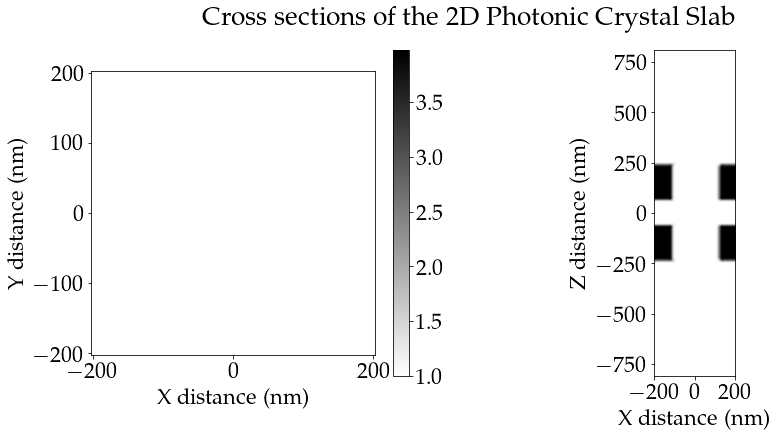

In [11]:
sim_params = resolution, cell, geometry
if plot == True:
    fig,  ax = plot_unit_cell_cross_sections(a, sim_params)

In [12]:
k_points = [mp.Vector3(),                      # Gamma
            mp.Vector3(2/3, 1/3),              # K
            mp.Vector3(0.5, 0.5),              # M
            mp.Vector3()]                      # Gamma

num_k = 30

k_points = mp.interpolate(num_k, k_points)

In [13]:
resolution = 32
num_bands = 2

In [14]:
num_period = 3
k_point = mp.Vector3(2/3,1/3,0.0) #K point

sim_params = geometry_lattice,  k_point, geometry, resolution, num_bands

field, converted_eps = calculate_ifield(sim_params, num_period)

Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 32 x 32 x 320.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0.866025, 0.5, 0)
     (0.866025, -0.5, 0)
     (0, 0, 10)
Cell volume = 8.66025
Reciprocal lattice vectors (/ 2 pi):
     (0.57735, 1, -0)
     (0.57735, -1, 0)
     (-0, 0, 0.1)
Geometric objects:
     block, center = (0,0,0.37037)
          size (1e+20,1e+20,0.444444)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-0.37037)
          size (1e+20,1e+20,0.444444)
          axes (1,0,0), (0,1,0), (0,0,1)
     prism, center = (0,0,0.37037)
          height 0.444444, axis (0,0,1), sidewall angle: 0 radians, 6 vertices:
          (0.185185,0.185185,0.148148)
          (0.37037,-0.185185,0.148148)
          (0.185185,-0.37037,0.148148)
          (-0.185185,-0.185185,0.148148)
          (-0.37037,0.185185,0.148148)
          (-0.185185,0.37037,0.148148)
    

In [20]:
num_band = 1

(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:title={'center':'YZ projection of I field'}, xlabel='Z distance (nm)', ylabel='Y distance (nm)'>)

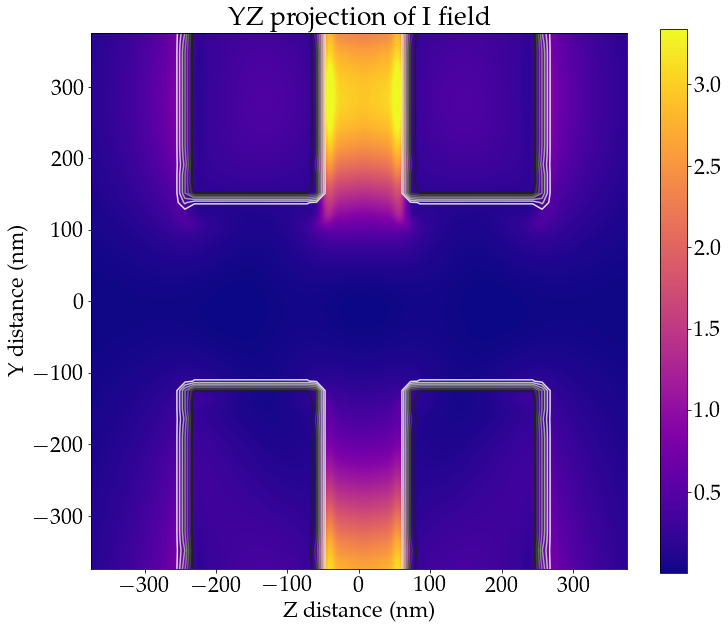

In [21]:
eps = converted_eps.T
a = 405  # nanometers


ylim = [-375,375]
zlim = [-375,375]
title = 'YZ projection of I field'

plot_field_2D_YZ(eps, np.array(field), a, resolution, num_band, ylim, zlim, title)

In [22]:
def plot_field_2D_XY(eps, field, a, resolution, num_band, xlim, ylim, title):

    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(title)
    
    z_half_index = int(np.shape(eps)[2] // 2)
    distance_conversion = resolution / a

    xmin, xmax = xlim
    ymin, ymax = ylim

    x_offset = int(np.array(np.shape(eps))[0] // 2)
    y_offset = int(np.array(np.shape(eps))[1] // 2)

    xmin_index = int(xmin * distance_conversion) + x_offset
    xmax_index = int(xmax * distance_conversion) + x_offset
    ymin_index = int(ymin * distance_conversion) + y_offset
    ymax_index = int(ymax * distance_conversion) + y_offset

    extent = [xmin, xmax, ymin, ymax]

    x_range = np.linspace(xmin, xmax, xmax_index - xmin_index)
    y_range = np.linspace(ymin, ymax, ymax_index - ymin_index)

    if len(np.shape(field)) == 4:

        field = np.array(field)[:, :, :, z_half_index]

    ax.contour(
        eps[xmin_index:xmax_index, ymin_index:ymax_index, z_half_index],
        extent=extent,
        cmap="binary",
    )

    posd1 = ax.imshow(
        np.real(field[num_band][xmin_index:xmax_index, ymin_index:ymax_index]),
        extent=extent,
        interpolation="spline36",
        cmap="plasma",
    )

    ax.set_xlabel("X distance (nm)")
    ax.set_ylabel("Y distance (nm)")

    fig.colorbar(posd1, ax=ax)

    return fig, ax

<ipython-input-22-3cfca66b5873>:29: UserWarning: No contour levels were found within the data range.
  ax.contour(


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:title={'center':'XY projection of I field'}, xlabel='X distance (nm)', ylabel='Y distance (nm)'>)

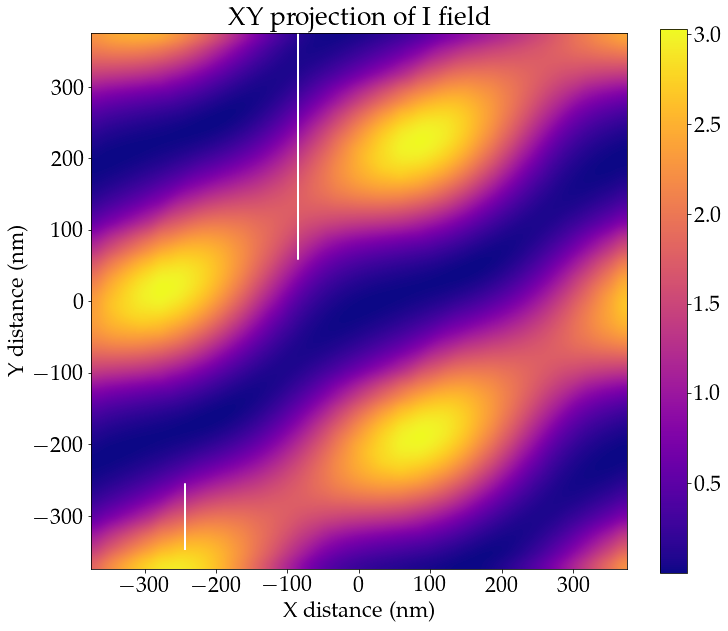

In [23]:
eps = converted_eps.T
a = 405  # nanometers


xlim = [-375,375]
ylim = [-375,375]
title = 'XY projection of I field'

plot_field_2D_XY(eps, np.array(field), a, resolution, num_band, xlim, ylim, title)

(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:title={'center':'XZ projection of I field'}, xlabel='Z distance (nm)', ylabel='X distance (nm)'>)

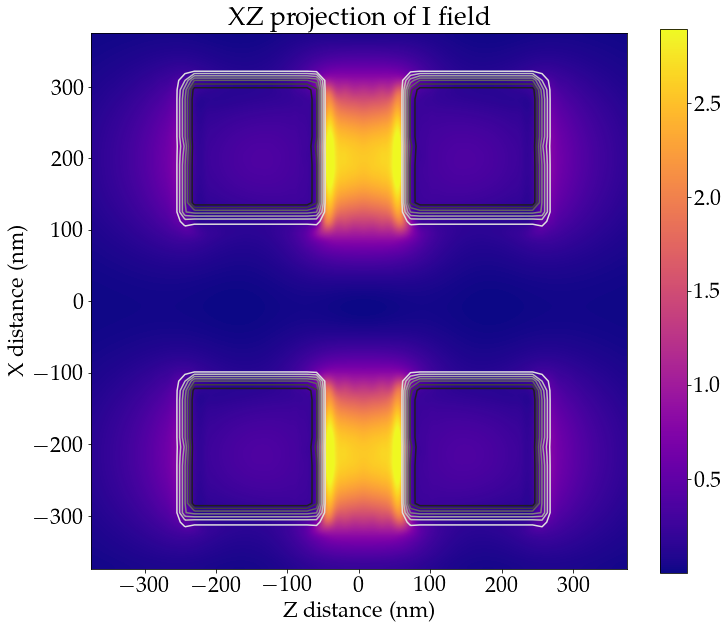

In [24]:
eps = converted_eps.T
a = 405  # nanometers


xlim = [-375,375]
zlim = [-375,375]
title = 'XZ projection of I field'

plot_field_2D_XZ(eps, np.array(field), a, resolution, num_band, xlim, zlim, title)

In [ ]:
8